### audio feature pulling stuff

In [1]:
import os
import pandas as pd
import librosa
import glob
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
from pydub import AudioSegment
import pickle as pkl

#### idea 1: librosa spectrum data

In [64]:
data, sampling = librosa.load('qantas.mp4')

In [66]:
sampling

22050

In [68]:
plt.figure(figsize=(12,4))

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

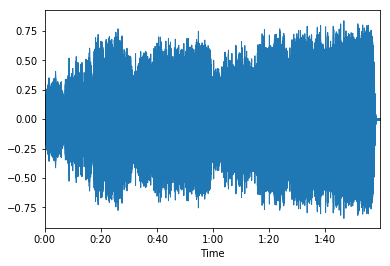

In [93]:
librosa.display.waveplot(data,sr=sampling)

#### idea 2: pyAudioAnalysis representation

In [28]:
sound = AudioSegment.from_file("H1H.mp4","mp4")
sound = sound.set_channels(1)
sound.export("H1H.wav", format="wav")

<_io.BufferedRandom name='H1H.wav'>

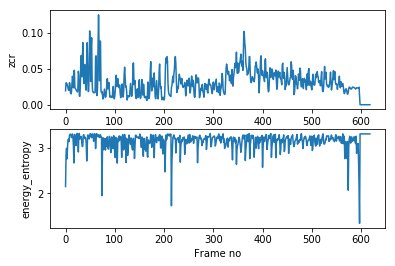

In [65]:
[Fs, x] = audioBasicIO.readAudioFile("H1H.wav");
F, f_names = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.1*Fs, 0.05*Fs);
plt.subplot(2,1,1); plt.plot(F[0,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[0]); 
plt.subplot(2,1,2); plt.plot(F[2,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[2]); plt.show()

## new extract_tfrecords_main file to incorporate audio features

In [80]:
%%writefile extract_tfrecords_main.py
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS-IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Produces tfrecord files similar to the YouTube-8M dataset.

It processes a CSV file containing lines like "<video_file>,<labels>", where
<video_file> must be a path of a video, and <labels> must be an integer list
joined with semi-colon ";". It processes all videos and outputs tfrecord file
onto --output_tfrecords_file.

It assumes that you have OpenCV installed and properly linked with ffmpeg (i.e.
function `cv2.VideoCapture().open('/path/to/some/video')` should return True).

The binary only processes the video stream (images) and not the audio stream. *not any more!
"""

import csv
import os
import sys

import cv2
import feature_extractor
import numpy
import tensorflow as tf
from tensorflow import app
from tensorflow import flags
import os
import pandas as pd
import librosa
import glob
import librosa.display
import ffmpeg
import subprocess
import matplotlib as mpl
mpl.use('TkAgg')
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
from pydub import AudioSegment


FLAGS = flags.FLAGS

# In OpenCV3.X, this is available as cv2.CAP_PROP_POS_MSEC
# In OpenCV2.X, this is available as cv2.cv.CV_CAP_PROP_POS_MSEC
CAP_PROP_POS_MSEC = 0

if __name__ == '__main__':
    # Required flags for input and output.
    flags.DEFINE_string('output_tfrecords_file', None,
                      'File containing tfrecords will be written at this path.')
    flags.DEFINE_string('input_videos_csv', None,
                      'CSV file with lines "<video_file>,<labels>", where '
                      '<video_file> must be a path of a video and <labels> '
                      'must be an integer list joined with semi-colon ";"')
    # Optional flags.
    flags.DEFINE_string('model_dir', os.path.join(os.getenv('HOME'), 'yt8m'),
                      'Directory to store model files. It defaults to ~/yt8m')

    # The following flags are set to match the YouTube-8M dataset format.
    flags.DEFINE_integer('frames_per_second', 25,
                       'This many frames per second will be processed')
    flags.DEFINE_boolean('skip_frame_level_features', False,
                       'If set, frame-level features will not be written: only '
                       'video-level features will be written with feature '
                       'names mean_*')
    flags.DEFINE_string('labels_feature_key', 'labels',
                      'Labels will be written to context feature with this '
                      'key, as int64 list feature.')
    flags.DEFINE_string('image_feature_key', 'rgb',
                      'Image features will be written to sequence feature with '
                      'this key, as bytes list feature, with only one entry, '
                      'containing quantized feature string.')
    flags.DEFINE_string('video_file_feature_key', 'id',
                      'Input <video_file> will be written to context feature '
                      'with this key, as bytes list feature, with only one '
                      'entry, containing the file path of the video. This '
                      'can be used for debugging but not for training or eval.')
    flags.DEFINE_boolean('insert_zero_audio_features', False,
                       'If set, inserts features with name "audio" to be 128-D '
                       'zero vectors. This allows you to use YouTube-8M '
                       'pre-trained model.')


def frame_iterator(filename, every_ms=40, max_num_frames=3000):
    """Uses OpenCV to iterate over all frames of filename at a given frequency.

    Args:
        filename: Path to video file (e.g. mp4)
        every_ms: The duration (in milliseconds) to skip between frames.
        max_num_frames: Maximum number of frames to process, taken from the
        beginning of the video.

    Yields:
        RGB frame with shape (image height, image width, channels)
    """
    video_capture = cv2.VideoCapture()
    if not video_capture.open(filename):
        print('Error: Cannot open video file ' + filename,file=sys.stderr)
        return
    last_ts = -99999  # The timestamp of last retrieved frame.
    num_retrieved = 0

    while num_retrieved < max_num_frames:
    # Skip frames
        while video_capture.get(CAP_PROP_POS_MSEC) < every_ms + last_ts:
            if not video_capture.read()[0]:
                return

        last_ts = video_capture.get(CAP_PROP_POS_MSEC)
        has_frames, frame = video_capture.read()
        if not has_frames:
            break
        yield frame
        num_retrieved += 1


def _int64_list_feature(int64_list):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=int64_list))

def _float_list_feature(float_list):
    return tf.train.Feature(float_list=tf.train.FloatList(value=float_list))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _make_bytes(int_array):
    if bytes == str:  # Python2
        return ''.join(map(chr, int_array))
    else:
        return bytes(int_array)


def quantize(features, min_quantized_value=-2.0, max_quantized_value=2.0):
    """Quantizes float32 `features` into string."""
    assert features.dtype == 'float32'
    assert len(features.shape) == 1  # 1-D array
    features = numpy.clip(features, min_quantized_value, max_quantized_value)
    quantize_range = max_quantized_value - min_quantized_value
    features = (features - min_quantized_value) * (255.0 / quantize_range)
    features = [int(round(f)) for f in features]

    return _make_bytes(features)


def main(unused_argv):
    extractor = feature_extractor.YouTube8MFeatureExtractor(FLAGS.model_dir)
    writer = tf.python_io.TFRecordWriter(FLAGS.output_tfrecords_file)
    total_written = 0
    total_error = 0
    for video_file, labels in csv.reader(open(FLAGS.input_videos_csv)):
        rgb_features = []
        sum_rgb_features = None
        for rgb in frame_iterator(
            video_file, every_ms=1000/FLAGS.frames_per_second):
                features = extractor.extract_rgb_frame_features(rgb[:, :, ::-1])
                if sum_rgb_features is None:
                    sum_rgb_features = features
                else:
                    sum_rgb_features += features
                rgb_features.append(_float_list_feature(features))
            
        if not rgb_features:
            print('Could not get features for ' + video_file, file=sys.stderr)
            total_error += 1
            continue
    
        mean_rgb_features = sum_rgb_features / len(rgb_features)
        if not FLAGS.insert_zero_audio_features:
            aud_features = []
            sum_aud_features = None
            sound = AudioSegment.from_file(video_file,video_file[-3:])
            sound = sound.set_channels(1)
            sound.export(video_file[:-4]+'.wav', format="wav")
            aud_file = video_file[:-4]+'.wav'
            [Fs, x] = audioBasicIO.readAudioFile(aud_file);
            a_feats, f_names = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.08*Fs, 0.04*Fs);
            a_feats = [numpy.array([a_feats[i][j] for i in range(len(a_feats))]) for j in range(len(a_feats[0]))]
            sum_aud_features = sum(a_feats)
            mean_aud_features = sum_aud_features / len(a_feats)
            for i in range(len(a_feats)):
                aud_features.append(_float_list_feature(a_feats[i]))
        # Create SequenceExample proto and write to output.
        feature_list = {
            FLAGS.image_feature_key: tf.train.FeatureList(feature=rgb_features),
        }
        context_features = {
            FLAGS.labels_feature_key: _int64_list_feature(
                sorted(map(int, labels.split(';')))),
            FLAGS.video_file_feature_key: _bytes_feature(_make_bytes(
                map(ord, video_file))),
            'mean_' + FLAGS.image_feature_key: tf.train.Feature(
                float_list=tf.train.FloatList(value=mean_rgb_features)),
        }

        if FLAGS.insert_zero_audio_features:
            aud_vec = [0] * 128
            feature_list['audio'] = tf.train.FeatureList(
            feature=[_bytes_feature(_make_bytes(aud_vec))] * len(rgb_features))
            context_features['mean_audio'] = tf.train.Feature(
            float_list=tf.train.FloatList(value=aud_vec))
        else:
            aud_vec = aud_features
            feature_list['audio'] = tf.train.FeatureList(feature=aud_vec)
            context_features['mean_audio'] = tf.train.Feature(
            float_list=tf.train.FloatList(value=mean_aud_features))

        if FLAGS.skip_frame_level_features:
            example = tf.train.SequenceExample(
                context=tf.train.Features(feature=context_features))
        else:
            example = tf.train.SequenceExample(
                context=tf.train.Features(feature=context_features),
                feature_lists=tf.train.FeatureLists(feature_list=feature_list))
        writer.write(example.SerializeToString())
        total_written += 1
        print(str(total_written)+' vids done')

    writer.close()
    print('Successfully encoded %i out of %i videos' % (
        total_written, total_written + total_error))


if __name__ == '__main__':
    app.run(main)


Overwriting extract_tfrecords_main.py


### looking at tfrecords file

In [128]:
import numpy as np
import tensorflow as tf
sess = tf.Session()
context_features = {
    'id' : tf.FixedLenFeature([1], dtype=tf.string),
    'labels': tf.FixedLenFeature([1],dtype=tf.int64),
    'mean_rgb': tf.FixedLenFeature([1024], dtype=tf.float32),
    'mean_audio': tf.FixedLenFeature([34],dtype=tf.float32)
}

sequence_features = {
    'rgb': tf.FixedLenSequenceFeature([1024], dtype=tf.float32),
    'audio': tf.FixedLenSequenceFeature([34], dtype=tf.float32)
}

def parse(record):
    parsed = tf.parse_single_sequence_example(
        record,
        context_features=context_features,
        sequence_features=sequence_features
    )
    return parsed



dataset = tf.data.TFRecordDataset('BIGDATA.tfrecord').map(lambda r: parse(r))

iterator = tf.data.Iterator.from_structure(dataset.output_types,
                                           dataset.output_shapes)
next_element = iterator.get_next()

training_init_op = iterator.make_initializer(dataset)

sess.run(training_init_op)
ne = []
for _ in range(118):
    ne.append(sess.run(next_element))

In [5]:
lens[29]

1499

In [4]:
lens = []
for i in range(118):
    lens.append(len(ne[i][1]['audio']))
lens

[374,
 750,
 751,
 376,
 374,
 374,
 749,
 798,
 374,
 375,
 374,
 799,
 375,
 748,
 749,
 750,
 375,
 750,
 749,
 374,
 748,
 851,
 1499,
 375,
 393,
 750,
 761,
 750,
 749,
 1499,
 1500,
 2532,
 750,
 374,
 747,
 374,
 375,
 376,
 371,
 763,
 374,
 750,
 2986,
 374,
 1524,
 749,
 774,
 763,
 376,
 751,
 799,
 374,
 749,
 375,
 424,
 749,
 748,
 375,
 749,
 376,
 374,
 1497,
 374,
 750,
 746,
 374,
 749,
 374,
 2235,
 823,
 2325,
 1048,
 1499,
 749,
 373,
 375,
 749,
 750,
 823,
 1499,
 374,
 371,
 750,
 798,
 2508,
 823,
 851,
 749,
 749,
 751,
 380,
 748,
 376,
 749,
 371,
 1048,
 374,
 397,
 346,
 374,
 375,
 371,
 750,
 750,
 375,
 374,
 749,
 751,
 373,
 374,
 749,
 374,
 374,
 775,
 750,
 748,
 750,
 374]

#### cutting similar-length vids to the same dimensions (generally cutting max. 0.2 seconds of either rgb or audio)

In [7]:
nerange = [3,4,5,8,9,10,12,16]
nerange = [int(i) for i in np.linspace(0,117,118)]
tenvidaud = np.array([[0]*34])
tenvidrgb = np.array([[0]*1024])
oklens = []
for i in nerange:
    if len(ne[i][1]['audio']) >= len(ne[i][1]['rgb']):   
        tenvidaud = np.concatenate((tenvidaud,ne[i][1]['audio'][:(len(ne[i][1]['rgb']))]))
        tenvidrgb = np.concatenate((tenvidrgb,ne[i][1]['rgb']))
    else:
        tenvidaud = np.concatenate((tenvidaud,ne[i][1]['audio']))
        tenvidrgb = np.concatenate((tenvidrgb,ne[i][1]['rgb'][:(len(ne[i][1]['audio']))]))
    oklens.append(len(tenvidrgb))
tenvidX = np.concatenate((tenvidrgb,tenvidaud),axis=1)

In [129]:
tenvidX.shape

(84871, 1058)

In [171]:
for i in range(len(hmm)):
    if lens[i] > 2000:
        print('ok')
        del hmm[i]

ok
ok
ok
ok
ok


In [166]:
hmm[112]

IndexError: list index out of range

In [133]:

hmm = [hmm[0:31]]+[hmm[32:42]]+[hmm[43:68]]+[hmm[69:70]]+[hmm[71:84]]+[hmm[85:]]


In [170]:
oklens2 = [0]+oklens+[None]
hmm = [tenvidX[oklens2[i]:oklens2[i+1]] for i in range(len(oklens))]
np.array(hmm)[0].shape

(372, 1058)

In [98]:
hmtst = [hmm[i] for i in range(len(hmm))]
hmtst[0] = np.vstack((hmtst[0],np.zeros(1058)))
hmtst[0] = np.vstack((hmtst[0],np.zeros(1058)))
np.array(hmtst)[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.25957787e-01, -3.67663622e-01, -8.32695484e-01, ...,
         1.68025821e-01,  1.31171793e-04,  4.60817032e-02],
       [ 5.85264325e-01, -3.61361653e-01, -8.44023645e-01, ...,
         1.05809949e-01,  2.96091940e-03,  4.27663885e-02],
       ...,
       [-2.64474332e-01, -4.35766548e-01, -6.19239986e-01, ...,
         1.64697766e-01,  1.46760003e-05,  4.52830493e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [173]:
pad = np.zeros(1058)
for i in range(len(hmm)):
    print('done'+str(i)+'vids')
    for j in range(1524-len(hmm[i])):
        hmm[i] = np.vstack((hmm[i],pad))



done0vids
done1vids
done2vids
done3vids
done4vids
done5vids
done6vids
done7vids
done8vids
done9vids
done10vids
done11vids
done12vids
done13vids
done14vids
done15vids
done16vids
done17vids
done18vids
done19vids
done20vids
done21vids
done22vids
done23vids
done24vids
done25vids
done26vids
done27vids
done28vids
done29vids
done30vids
done31vids
done32vids
done33vids
done34vids
done35vids
done36vids
done37vids
done38vids
done39vids
done40vids
done41vids
done42vids
done43vids
done44vids
done45vids
done46vids
done47vids
done48vids
done49vids
done50vids
done51vids
done52vids
done53vids
done54vids
done55vids
done56vids
done57vids
done58vids
done59vids
done60vids
done61vids
done62vids
done63vids
done64vids
done65vids
done66vids
done67vids
done68vids
done69vids
done70vids
done71vids
done72vids
done73vids
done74vids
done75vids
done76vids
done77vids
done78vids
done79vids
done80vids
done81vids
done82vids
done83vids
done84vids
done85vids
done86vids
done87vids
done88vids
done89vids
done90vids
done91vid

In [175]:
hmm[1].shape

(1524, 1058)

In [221]:
np.zeros(1058)

array([0., 0., 0., ..., 0., 0., 0.])

In [177]:
import pickle as pkl
with open('padchop.txt','wb') as f:
    pkl.dump(hmm,f)

## clustering with PCA and t-SNE

#### define colours by video

In [155]:
y = np.ones(84871)
z = 1
last_x = 0
y2 = []
for x in oklens:
    if z == 1:
        y[0:x] = y[0:x]
        z += 1
        last_x = x
    else:
        y[last_x:x] = y[last_x:x]*z
        z += 1
        last_x = x
for i in range(len(y)):
    y2.append([y[i]])

y = np.array(y2)
    


#### define colours temporally

In [105]:
y = np.ones(2995)
z = 1
last_x = 0
y2 = []
for x in range(len(y)):
    y[x] = y[x]*z
    z+= 1
    if x in oklens:
        z = 1
for i in range(len(y)):
    y2.append([y[i]])

y = np.array(y2)
y

array([[  1.],
       [  2.],
       [  3.],
       ...,
       [372.],
       [373.],
       [374.]])

#### turn data into pandas dataframe

In [156]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from ggplot import *
import time

X = tenvidX
y = y

print(X.shape, y.shape)

feat_cols = ['rgb feat'+str(i) for i in range(X.shape[1])]

df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i+100))

X, y = None, None

print('Size of the dataframe: {}'.format(df.shape))

(84871, 1058) (84871, 1)
Size of the dataframe: (84871, 1059)


#### visualise pca for 3 components

In [82]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

chart = ggplot(df.loc[:,:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

Explained variation per principal component: [0.07900068 0.05173955 0.04461007]


#### t-SNE for above 3 components w/ visualisation

In [84]:
n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[:,feat_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_tsne = df.loc[:,:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2995 samples in 0.115s...
[t-SNE] Computed neighbors for 2995 samples in 16.752s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2995
[t-SNE] Computed conditional probabilities for sample 2000 / 2995
[t-SNE] Computed conditional probabilities for sample 2995 / 2995
[t-SNE] Mean sigma: 7.784855
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.054173
[t-SNE] KL divergence after 300 iterations: 0.867010
t-SNE done! Time elapsed: 23.91643500328064 seconds


#### PCA

In [158]:
pca_50 = PCA(n_components=300)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values)
print('Cumulative explained variation for 300 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 300 principal components: 0.6802881023015226


#### t-SNE

In [159]:
n_sne = 10000
import time
from sklearn.manifold import TSNE

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_pca_results = tsne.fit_transform(pca_result_50[:])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 84871 samples in 1.982s...
[t-SNE] Computed neighbors for 84871 samples in 3743.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 84871
[t-SNE] Computed conditional probabilities for sample 2000 / 84871
[t-SNE] Computed conditional probabilities for sample 3000 / 84871
[t-SNE] Computed conditional probabilities for sample 4000 / 84871
[t-SNE] Computed conditional probabilities for sample 5000 / 84871
[t-SNE] Computed conditional probabilities for sample 6000 / 84871
[t-SNE] Computed conditional probabilities for sample 7000 / 84871
[t-SNE] Computed conditional probabilities for sample 8000 / 84871
[t-SNE] Computed conditional probabilities for sample 9000 / 84871
[t-SNE] Computed conditional probabilities for sample 10000 / 84871
[t-SNE] Computed conditional probabilities for sample 11000 / 84871
[t-SNE] Computed conditional probabilities for sample 12000 / 84871
[t-SNE] Computed conditional probabilities for

#### visualise

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

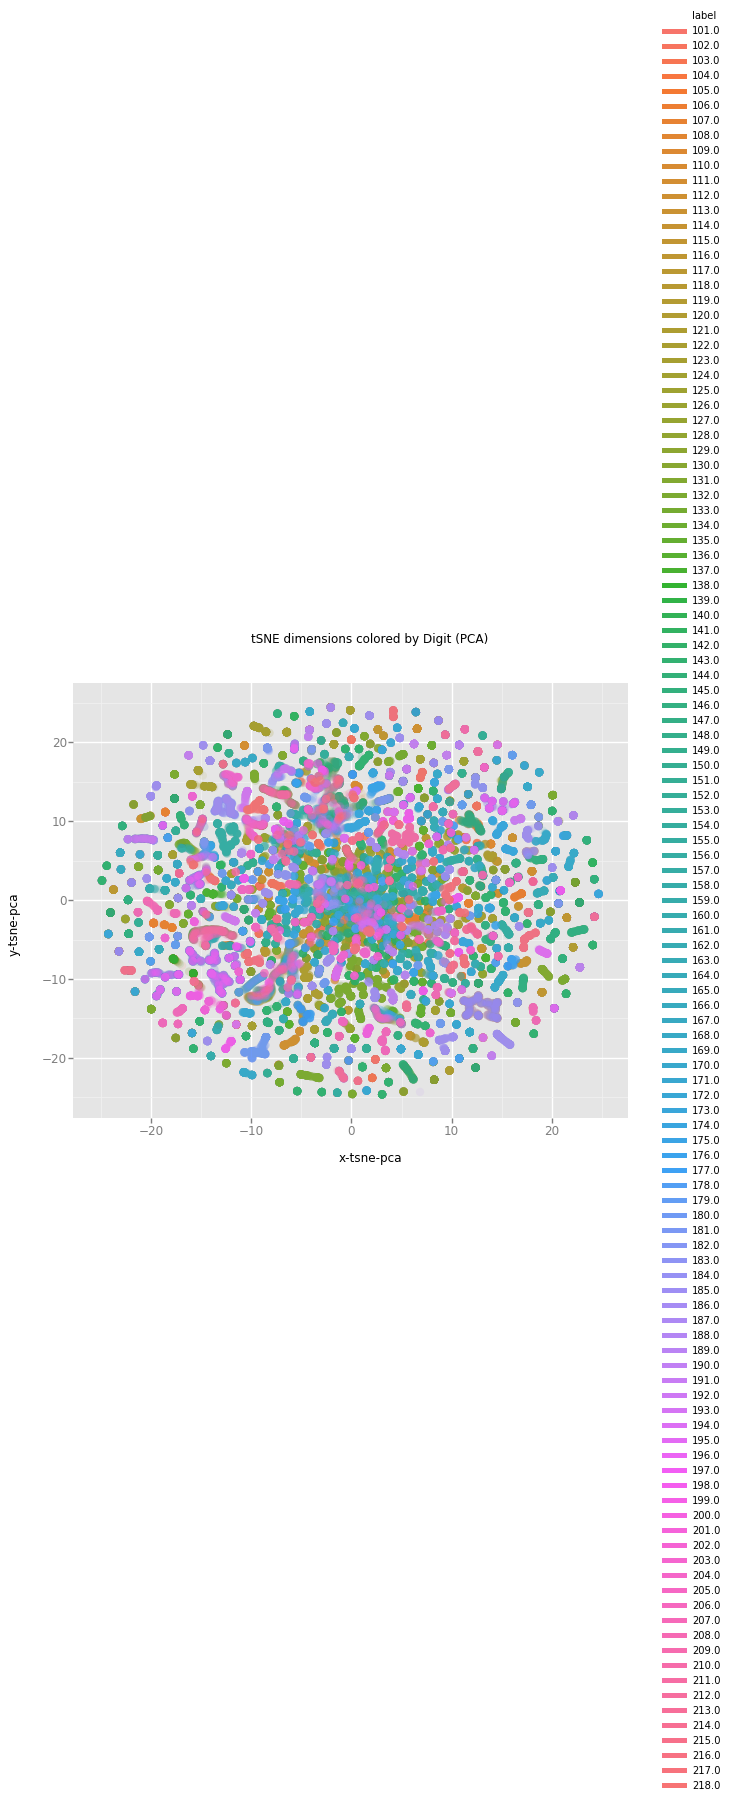

In [161]:
from ggplot import *
df_tsne = None
df_tsne = df.loc[:,:].copy()
df_tsne['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne['y-tsne-pca'] = tsne_pca_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne-pca', y='y-tsne-pca', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by Digit (PCA)")

chart.save('8vids_highres_audrgb2.png')


#### useful template for cleaning txt file

In [9]:
infile = r"cleaned_files.txt"
outfile = r"cleaned_files2.txt"

delete_list = [";"]
fin=open(infile,"r")
fout = open(outfile,"w+")
for line in fin:
    for word in delete_list:
        line = line.replace(word, ",")
    fout.write(line)
fin.close()
fout.close()